Anomaly i.e any value out of the usual group of values can be identified using Mahalanobis distance(MD).  
This distance is used if the data is multivariate and if there may be correlation between the variables.  
Euclidean distance can not be applied in that case.  
In this analysis , the MD of the data sample for normal fan operation accelerometer readings are used as the baseline and for any readings if the MD is greater than the baseline , reading can be treated as an anomaly.  

In [18]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sn
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Print versions
!python --version
print('Numpy ' + np.__version__)


Python 3.8.3
Numpy 1.19.5


In [3]:
from sklearn.metrics import confusion_matrix

In [4]:
from sklearn.model_selection import train_test_split

Read in the normal and anomaly data.   


In [5]:
normal_features_df  = pd.read_csv("normal_features_df.csv")

In [6]:
anomaly_features_df = pd.read_csv("anomaly_features_df.csv")

In [7]:
normal_features_df.shape

(201, 4)

In [8]:
normal_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mad_x    201 non-null    float64
 1   mad_y    201 non-null    float64
 2   mad_z    201 non-null    float64
 3   anomaly  201 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 6.4 KB


In [9]:
normal_features_df.head()

,mad_x,mad_y,mad_z,anomaly
0,0.015381,0.011718,0.005860,0
1,0.015625,0.012939,0.006348,0
2,0.015137,0.011963,0.007080,0
3,0.014648,0.011963,0.006348,0
4,0.014160,0.011718,0.005859,0


In [10]:
anomaly_features_df.shape

(201, 4)

In [11]:
anomaly_features_df.head()

,mad_x,mad_y,mad_z,anomaly
0,0.011231,0.009033,0.005859,1
1,0.009766,0.009277,0.006347,1
2,0.011718,0.010253,0.006836,1
3,0.010254,0.009765,0.006347,1
4,0.010254,0.009521,0.006836,1


In [12]:
anomaly_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mad_x    201 non-null    float64
 1   mad_y    201 non-null    float64
 2   mad_z    201 non-null    float64
 3   anomaly  201 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 6.4 KB


Split the features into train, validate and test sets.  

Select the first 175 records so that the remaining 25 records can be used for final testing later.  

In [13]:
normal_features = normal_features_df[['mad_x','mad_y','mad_z']][:175]
X_train_val, X_test, y_train_val, y_test  = train_test_split(normal_features, normal_features_df['anomaly'][:175], random_state = 1 , test_size = 0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val , random_state = 1 , test_size = 0.2)

#
print("\n X_train : {}".format(X_train.shape))
print("\n X_val : {}".format(X_val.shape))
print("\n X_test : {}".format(X_test.shape))
#
print("\n y_train : {}".format(y_train.shape))
print("\n y_val : {}".format(y_val.shape))
print("\n y_test : {}".format(y_test.shape))


 X_train : (118, 3)

 X_val : (30, 3)

 X_test : (27, 3)

 y_train : (118,)

 y_val : (30,)

 y_test : (27,)


The following code is taken from https://github.com/ShawnHymel/tinyml-example-anomaly-detection/blob/master/mahalanobis_distance/anomaly-detection-training-mahalanobis-distance.ipynb

In [14]:
# Calculate mahalanobis distance of x from group described by mu, cov
# Based on: https://www.machinelearningplus.com/statistics/mahalanobis-distance/
def mahalanobis(x, mu, cov):
    x_minus_mu = x - mu
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    if mahal.shape == ():
        return mahal
    else:
        return mahal.diagonal()

In [15]:
# Use training data (normal) to calculate mean and covariance matrices
model_mu = np.mean(X_train, axis=0)
model_cov = np.cov(X_train.T)
print(model_mu)
print(model_cov)

mad_x    0.014951
mad_y    0.012006
mad_z    0.006288
dtype: float64
[[ 8.68666399e-07  2.66955966e-07 -1.48766819e-08]
 [ 2.66955966e-07  2.87979285e-07 -3.66031820e-08]
 [-1.48766819e-08 -3.66031820e-08  1.23241152e-07]]


Average MD for normal validation set: 3.3009472452871256
Standard deviation of MDs for normal validation set: 2.6536497450032774
Recommended threshold (3x std dev + avg): 11.261896480296958


(array([6., 1., 1., 5., 2., 2., 0., 3., 1., 0., 2., 0., 1., 1., 1., 1., 1.,
        1., 0., 1.]),
 array([0.10853449, 0.57168218, 1.03482986, 1.49797755, 1.96112523,
        2.42427292, 2.8874206 , 3.35056828, 3.81371597, 4.27686365,
        4.74001134, 5.20315902, 5.66630671, 6.12945439, 6.59260208,
        7.05574976, 7.51889745, 7.98204513, 8.44519281, 8.9083405 ,
        9.37148818]),
 <a list of 20 Patch objects>)

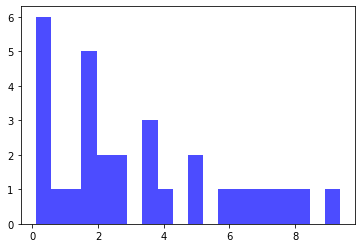

In [19]:
# Calculate the mahalanobis distance for each validation sample
normal_mds = mahalanobis(X_val, model_mu, model_cov)
print('Average MD for normal validation set:', np.average(normal_mds))
print('Standard deviation of MDs for normal validation set:', np.std(normal_mds))
print('Recommended threshold (3x std dev + avg):', (3*np.std(normal_mds)) + np.average(normal_mds))
fig, ax = plt.subplots(1,1)
ax.hist(normal_mds, bins=20, label='normal', color='blue', alpha=0.7)

Average MD for normal test set: 3.5490591550485666
Standard deviation of MDs for normal test set: 2.4766375021335136


(array([6., 1., 1., 5., 2., 2., 0., 3., 1., 0., 2., 0., 1., 1., 1., 1., 1.,
        1., 0., 1.]),
 array([0.10853449, 0.57168218, 1.03482986, 1.49797755, 1.96112523,
        2.42427292, 2.8874206 , 3.35056828, 3.81371597, 4.27686365,
        4.74001134, 5.20315902, 5.66630671, 6.12945439, 6.59260208,
        7.05574976, 7.51889745, 7.98204513, 8.44519281, 8.9083405 ,
        9.37148818]),
 <a list of 20 Patch objects>)

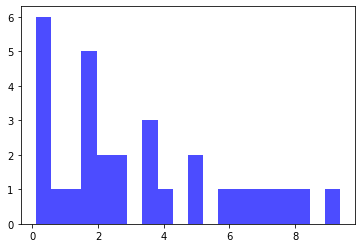

In [24]:
# Calculate the mahalanobis distance for test sample 
normal_mds_test = mahalanobis(X_test, model_mu, model_cov)
print('Average MD for normal test set:', np.average(normal_mds_test))
print('Standard deviation of MDs for normal test set:', np.std(normal_mds_test))

fig, ax = plt.subplots(1,1)
ax.hist(normal_mds, bins=20, label='normal', color='blue', alpha=0.7)

Select the first 175 records of anomaly_features so that last 25 can be used for final testing.  

In [21]:
# Calculate the mahalanobis distance for each anomaly sample
anomaly_features = anomaly_features_df[['mad_x','mad_y','mad_z']][:175]

anomaly_mds = mahalanobis(anomaly_features, model_mu, model_cov)
print('Average MD for anomaly set:', np.average(anomaly_mds))
print('Standard deviation of MDs for validation set:', np.std(anomaly_mds))

Average MD for anomaly set: 40.315220854944776
Standard deviation of MDs for validation set: 9.033521569517193


Text(0.5, 1.0, 'Normal validation Vs Anomaly')

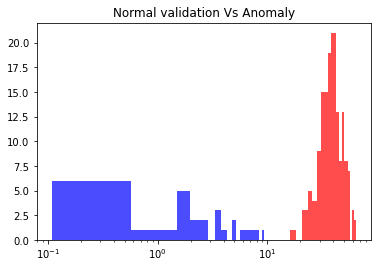

In [23]:
# Plot histograms of normal validation vs. anomaly sets (MSEs)
fig, ax = plt.subplots(1,1)
plt.xscale("log")
ax.hist(normal_mds, bins=20, label='normal', color='blue', alpha=0.7)
ax.hist(anomaly_mds, bins=20, label='anomaly', color='red', alpha=0.7)
plt.title("Normal validation Vs Anomaly")

Text(0.5, 1.0, 'Normal test Vs Anomaly')

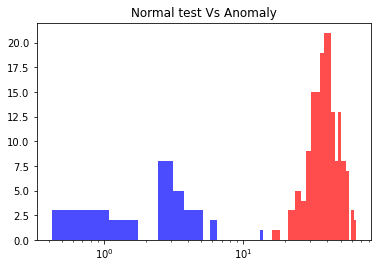

In [25]:
# Plot histograms of normal test vs. anomaly sets (MSEs)
fig, ax = plt.subplots(1,1)
plt.xscale("log")
ax.hist(normal_mds_test, bins=20, label='normal', color='blue', alpha=0.7)
ax.hist(anomaly_mds, bins=20, label='anomaly', color='red', alpha=0.7)
plt.title("Normal test Vs Anomaly")

In [26]:
# Choose a threshold
anomaly_threshold = 11.261896480296958

In [45]:
# Create a classifier (0 = normal, 1 = anomaly)
def detect_anomaly(x, model_mu, model_cov, threshold=0):
    md = mahalanobis(x, model_mu, model_cov)
    if md > threshold:
        return 1
    else:
        return 0

In [46]:
y_test_pred = X_test.apply(lambda x: detect_anomaly(x, model_mu, model_cov, anomaly_threshold), axis = 1)
y_test_pred

93     0
114    0
19     0
69     0
53     0
135    0
126    0
14     0
106    0
112    0
11     0
4      0
105    0
42     0
102    0
110    0
149    0
35     0
123    1
31     0
51     0
75     0
169    0
73     0
40     0
85     0
47     0
dtype: int64

As shown above, the model  has identified  all the normal test set  as 'non-anomaly'.

Check for anomaly records.  

In [47]:

anomaly_pred = anomaly_features.apply(lambda x: detect_anomaly(x, model_mu, model_cov, anomaly_threshold), axis = 1)
anomaly_pred

0      1
1      1
2      1
3      1
4      1
      ..
170    1
171    1
172    1
173    1
174    1
Length: 175, dtype: int64

Test with a mix of normal features and anomaly features.  
We had retained 25 records of normal_features_df as well as anomaly_features_df of file for this testing.   

In [48]:
normal_features.shape

(175, 3)

In [49]:
all_features = normal_features_df.copy()
all_features = all_features[176:]
all_features.shape

(25, 4)

In [50]:
all_features.tail()

,mad_x,mad_y,mad_z,anomaly
196,0.015137,0.012207,0.006348,0
197,0.015381,0.012696,0.006348,0
198,0.014404,0.011231,0.005859,0
199,0.014648,0.012207,0.006836,0
200,0.016114,0.011719,0.006347,0


In [51]:
anomaly_features_df[176:]

,mad_x,mad_y,mad_z,anomaly
176,0.009277,0.007813,0.006836,1
177,0.009766,0.009766,0.006348,1
178,0.009277,0.008301,0.006348,1
179,0.009765,0.008301,0.007080,1
180,0.009277,0.009277,0.006836,1
181,0.010254,0.009277,0.006348,1
182,0.009765,0.009033,0.006347,1
183,0.008789,0.008301,0.006347,1
184,0.009522,0.008545,0.006348,1
185,0.008789,0.009277,0.006836,1


In [52]:
all_features = all_features.append(anomaly_features_df[176:], ignore_index = True)
all_features.shape

(50, 4)

In [53]:
all_features.tail()

,mad_x,mad_y,mad_z,anomaly
45,0.008301,0.008789,0.006348,1
46,0.009278,0.008301,0.006347,1
47,0.009277,0.008301,0.006348,1
48,0.009765,0.008789,0.006348,1
49,0.009766,0.008789,0.006836,1


Shuffle the  records so that there is a mix of anomaly and  non anomaly.  

In [54]:
all_features = all_features.sample(frac =1)
all_features

,mad_x,mad_y,mad_z,anomaly
17,0.014404,0.012207,0.006348,0
21,0.015381,0.012696,0.006348,0
6,0.014161,0.011719,0.005859,0
16,0.014648,0.012207,0.005859,0
3,0.014893,0.011231,0.005859,0
37,0.009766,0.008789,0.007324,1
1,0.015137,0.012207,0.006104,0
33,0.009522,0.008545,0.006348,1
26,0.009766,0.009766,0.006348,1
8,0.016601,0.012207,0.006347,0


With the mix of normal and anomaly records , check if the Mahalanobis Distance can accurately identify anomaly.   

In [55]:
final_test_data = all_features[['mad_x','mad_y','mad_z']]

all_features_pred = final_test_data.apply(lambda x: detect_anomaly(x, model_mu, model_cov, anomaly_threshold), axis = 1)
all_features_pred

17    0
21    0
6     0
16    0
3     0
37    1
1     0
33    1
26    1
8     0
12    0
39    1
18    0
10    0
35    1
46    1
29    1
34    1
44    1
4     0
40    1
24    0
0     0
19    0
13    0
15    0
23    0
49    1
41    1
30    1
42    1
27    1
7     0
5     0
20    0
22    0
47    1
25    1
43    1
48    1
2     0
9     0
36    1
32    1
11    0
45    1
31    1
28    1
38    1
14    0
dtype: int64

In [56]:
cm = confusion_matrix(all_features['anomaly'], all_features_pred)
cm

array([[25,  0],
       [ 0, 25]])

Text(33.0, 0.5, 'Actual')

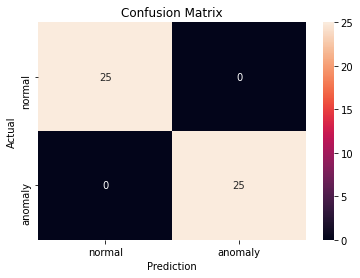

In [57]:
# Plot the confusion matrix
df_cm = pd.DataFrame(cm, index=['normal', 'anomaly'], columns=['normal', 'anomaly'])
plt.figure()
sn.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')